# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [4]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128


## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


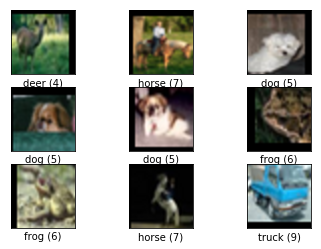

torch.Size([128, 3, 32, 32])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.__next__()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

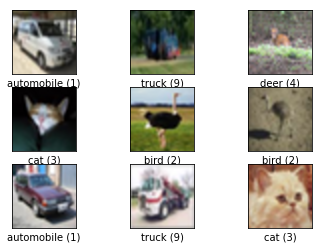

torch.Size([128, 3, 32, 32])


In [11]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.__next__()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
means: [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds: [0.24697121702736, 0.24696766978537033, 0.2469719877121087]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [4]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [15]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [5]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [7]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.116
1 	100 	1.888
1 	150 	1.773
1 	200 	1.719
1 	250 	1.637
1 	300 	1.619
1 	350 	1.555
train_err: 0.61566 test_err: 0.6069
2 	50 	1.476
2 	100 	1.421
2 	150 	1.374
2 	200 	1.332
2 	250 	1.275
2 	300 	1.265
2 	350 	1.206
train_err: 0.51664 test_err: 0.4997
3 	50 	1.142
3 	100 	1.125
3 	150 	1.099
3 	200 	1.085
3 	250 	1.054
3 	300 	1.009
3 	350 	0.995
train_err: 0.38914 test_err: 0.382
4 	50 	0.924
4 	100 	0.932
4 	150 	0.902
4 	200 	0.885
4 	250 	0.888
4 	300 	0.863
4 	350 	0.853
train_err: 0.29854 test_err: 0.2992
5 	50 	0.816
5 	100 	0.796
5 	150 	0.815
5 	200 	0.789
5 	250 	0.762
5 	300 	0.774
5 	350 	0.770
train_err: 0.28306 test_err: 0.2897
6 	50 	0.734
6 	100 	0.755
6 	150 	0.727
6 	200 	0.730
6 	250 	0.719
6 	300 	0.738
6 	350 	0.680
train_err: 0.27448 test_err: 0.2744
7 	50 	0.653
7 	100 	0.694
7 	150 	0.684
7 	200 	0.684
7 	250 	0.666
7 	300 

59 	200 	0.303
59 	250 	0.331
59 	300 	0.321
59 	350 	0.320
train_err: 0.13712 test_err: 0.1685
60 	50 	0.291
60 	100 	0.311
60 	150 	0.315
60 	200 	0.324
60 	250 	0.307
60 	300 	0.305
60 	350 	0.316
train_err: 0.11916 test_err: 0.1568
61 	50 	0.286
61 	100 	0.301
61 	150 	0.309
61 	200 	0.328
61 	250 	0.299
61 	300 	0.318
61 	350 	0.288
train_err: 0.12008 test_err: 0.1563
62 	50 	0.299
62 	100 	0.302
62 	150 	0.277
62 	200 	0.294
62 	250 	0.316
62 	300 	0.296
62 	350 	0.327
train_err: 0.1325 test_err: 0.1657
63 	50 	0.282
63 	100 	0.299
63 	150 	0.293
63 	200 	0.300
63 	250 	0.295
63 	300 	0.318
63 	350 	0.330
train_err: 0.19158 test_err: 0.2222
64 	50 	0.282
64 	100 	0.294
64 	150 	0.297
64 	200 	0.288
64 	250 	0.296
64 	300 	0.313
64 	350 	0.315
train_err: 0.10678 test_err: 0.1476
65 	50 	0.272
65 	100 	0.309
65 	150 	0.298
65 	200 	0.299
65 	250 	0.302
65 	300 	0.308
65 	350 	0.313
train_err: 0.1467 test_err: 0.1773
66 	50 	0.282
66 	100 	0.292
66 	150 	0.269
66 	200 	0.293
66 	250

117 	150 	0.065
117 	200 	0.068
117 	250 	0.071
117 	300 	0.063
117 	350 	0.066
train_err: 0.01732 test_err: 0.0999
118 	50 	0.061
118 	100 	0.068
118 	150 	0.059
118 	200 	0.062
118 	250 	0.060
118 	300 	0.061
118 	350 	0.067
train_err: 0.01884 test_err: 0.1013
119 	50 	0.060
119 	100 	0.066
119 	150 	0.063
119 	200 	0.070
119 	250 	0.065
119 	300 	0.075
119 	350 	0.067
train_err: 0.01644 test_err: 0.0972
120 	50 	0.063
120 	100 	0.058
120 	150 	0.061
120 	200 	0.060
120 	250 	0.063
120 	300 	0.064
120 	350 	0.070
train_err: 0.01744 test_err: 0.0998
121 	50 	0.058
121 	100 	0.067
121 	150 	0.065
121 	200 	0.064
121 	250 	0.065
121 	300 	0.064
121 	350 	0.061
train_err: 0.0184 test_err: 0.1014
122 	50 	0.063
122 	100 	0.066
122 	150 	0.060
122 	200 	0.065
122 	250 	0.057
122 	300 	0.065
122 	350 	0.065
train_err: 0.01578 test_err: 0.0976
123 	50 	0.059
123 	100 	0.058
123 	150 	0.064
123 	200 	0.064
123 	250 	0.066
123 	300 	0.062
123 	350 	0.062
train_err: 0.01884 test_err: 0.1024
124

9 	50 	0.913
9 	100 	0.921
9 	150 	0.902
9 	200 	0.909
9 	250 	0.882
9 	300 	0.864
9 	350 	0.886
train_err: 0.35178 test_err: 0.3434
10 	50 	0.802
10 	100 	0.836
10 	150 	0.813
10 	200 	0.809
10 	250 	0.857
10 	300 	0.824
10 	350 	0.857
train_err: 0.38952 test_err: 0.3947
11 	50 	0.777
11 	100 	0.791
11 	150 	0.788
11 	200 	0.773
11 	250 	0.805
11 	300 	0.799
11 	350 	0.769
train_err: 0.36684 test_err: 0.374
12 	50 	0.771
12 	100 	0.730
12 	150 	0.742
12 	200 	0.745
12 	250 	0.760
12 	300 	0.750
12 	350 	0.749
train_err: 0.2734 test_err: 0.2707
13 	50 	0.715
13 	100 	0.721
13 	150 	0.699
13 	200 	0.728
13 	250 	0.725
13 	300 	0.703
13 	350 	0.713
train_err: 0.28976 test_err: 0.2956
14 	50 	0.717
14 	100 	0.677
14 	150 	0.690
14 	200 	0.686
14 	250 	0.696
14 	300 	0.668
14 	350 	0.670
train_err: 0.3532 test_err: 0.3416
15 	50 	0.667
15 	100 	0.656
15 	150 	0.649
15 	200 	0.651
15 	250 	0.675
15 	300 	0.666
15 	350 	0.647
train_err: 0.22476 test_err: 0.2333
16 	50 	0.640
16 	100 	0.615
1

train_err: 0.1532 test_err: 0.1837
68 	50 	0.353
68 	100 	0.351
68 	150 	0.354
68 	200 	0.368
68 	250 	0.375
68 	300 	0.375
68 	350 	0.378
train_err: 0.16894 test_err: 0.189
69 	50 	0.351
69 	100 	0.351
69 	150 	0.357
69 	200 	0.345
69 	250 	0.352
69 	300 	0.374
69 	350 	0.363
train_err: 0.19656 test_err: 0.2237
70 	50 	0.364
70 	100 	0.350
70 	150 	0.344
70 	200 	0.367
70 	250 	0.365
70 	300 	0.354
70 	350 	0.356
train_err: 0.19896 test_err: 0.2158
71 	50 	0.360
71 	100 	0.354
71 	150 	0.336
71 	200 	0.367
71 	250 	0.348
71 	300 	0.350
71 	350 	0.373
train_err: 0.12164 test_err: 0.1562
72 	50 	0.334
72 	100 	0.340
72 	150 	0.350
72 	200 	0.365
72 	250 	0.372
72 	300 	0.378
72 	350 	0.372
train_err: 0.13966 test_err: 0.1701
73 	50 	0.306
73 	100 	0.358
73 	150 	0.370
73 	200 	0.358
73 	250 	0.361
73 	300 	0.344
73 	350 	0.357
train_err: 0.19066 test_err: 0.2181
74 	50 	0.338
74 	100 	0.345
74 	150 	0.342
74 	200 	0.348
74 	250 	0.363
74 	300 	0.350
74 	350 	0.356
train_err: 0.1679 test

125 	150 	0.063
125 	200 	0.060
125 	250 	0.058
125 	300 	0.050
125 	350 	0.063
train_err: 0.01452 test_err: 0.1029
126 	50 	0.056
126 	100 	0.054
126 	150 	0.050
126 	200 	0.051
126 	250 	0.053
126 	300 	0.059
126 	350 	0.060
train_err: 0.01256 test_err: 0.1016
127 	50 	0.055
127 	100 	0.054
127 	150 	0.047
127 	200 	0.048
127 	250 	0.055
127 	300 	0.052
127 	350 	0.046
train_err: 0.01252 test_err: 0.1002
128 	50 	0.046
128 	100 	0.047
128 	150 	0.050
128 	200 	0.050
128 	250 	0.053
128 	300 	0.047
128 	350 	0.050
train_err: 0.0131 test_err: 0.102
129 	50 	0.049
129 	100 	0.047
129 	150 	0.043
129 	200 	0.051
129 	250 	0.056
129 	300 	0.047
129 	350 	0.046
train_err: 0.012 test_err: 0.1022
130 	50 	0.049
130 	100 	0.046
130 	150 	0.053
130 	200 	0.049
130 	250 	0.046
130 	300 	0.046
130 	350 	0.042
train_err: 0.01152 test_err: 0.1004
131 	50 	0.043
131 	100 	0.044
131 	150 	0.048
131 	200 	0.052
131 	250 	0.044
131 	300 	0.046
131 	350 	0.052
train_err: 0.0114 test_err: 0.1012
132 	50

17 	250 	0.961
17 	300 	0.912
17 	350 	0.924
train_err: 0.40676 test_err: 0.4095
18 	50 	0.914
18 	100 	0.887
18 	150 	0.891
18 	200 	0.897
18 	250 	0.874
18 	300 	0.877
18 	350 	0.894
train_err: 0.3298 test_err: 0.3225
19 	50 	0.882
19 	100 	0.871
19 	150 	0.874
19 	200 	0.850
19 	250 	0.855
19 	300 	0.874
19 	350 	0.841
train_err: 0.3517 test_err: 0.358
20 	50 	0.838
20 	100 	0.831
20 	150 	0.840
20 	200 	0.858
20 	250 	0.810
20 	300 	0.844
20 	350 	0.809
train_err: 0.31028 test_err: 0.308
21 	50 	0.828
21 	100 	0.817
21 	150 	0.808
21 	200 	0.800
21 	250 	0.801
21 	300 	0.826
21 	350 	0.817
train_err: 0.37604 test_err: 0.3887
22 	50 	0.798
22 	100 	0.793
22 	150 	0.803
22 	200 	0.809
22 	250 	0.756
22 	300 	0.796
22 	350 	0.799
train_err: 0.31054 test_err: 0.3159
23 	50 	0.750
23 	100 	0.778
23 	150 	0.788
23 	200 	0.793
23 	250 	0.744
23 	300 	0.772
23 	350 	0.777
train_err: 0.31336 test_err: 0.3172
24 	50 	0.752
24 	100 	0.736
24 	150 	0.740
24 	200 	0.764
24 	250 	0.742
24 	300 	

76 	100 	0.478
76 	150 	0.477
76 	200 	0.496
76 	250 	0.492
76 	300 	0.479
76 	350 	0.465
train_err: 0.20316 test_err: 0.214
77 	50 	0.445
77 	100 	0.480
77 	150 	0.498
77 	200 	0.474
77 	250 	0.475
77 	300 	0.506
77 	350 	0.468
train_err: 0.18768 test_err: 0.2095
78 	50 	0.464
78 	100 	0.464
78 	150 	0.465
78 	200 	0.454
78 	250 	0.491
78 	300 	0.505
78 	350 	0.484
train_err: 0.19398 test_err: 0.2073
79 	50 	0.471
79 	100 	0.467
79 	150 	0.459
79 	200 	0.490
79 	250 	0.473
79 	300 	0.458
79 	350 	0.461
train_err: 0.20328 test_err: 0.2244
80 	50 	0.480
80 	100 	0.445
80 	150 	0.495
80 	200 	0.472
80 	250 	0.456
80 	300 	0.489
80 	350 	0.451
train_err: 0.20388 test_err: 0.224
81 	50 	0.445
81 	100 	0.448
81 	150 	0.467
81 	200 	0.487
81 	250 	0.481
81 	300 	0.465
81 	350 	0.451
train_err: 0.20232 test_err: 0.2243
82 	50 	0.488
82 	100 	0.460
82 	150 	0.478
82 	200 	0.444
82 	250 	0.476
82 	300 	0.464
82 	350 	0.482
train_err: 0.18708 test_err: 0.1997
83 	50 	0.445
83 	100 	0.479
83 	150

133 	150 	0.124
133 	200 	0.119
133 	250 	0.121
133 	300 	0.109
133 	350 	0.120
train_err: 0.03462 test_err: 0.1161
134 	50 	0.110
134 	100 	0.119
134 	150 	0.116
134 	200 	0.122
134 	250 	0.117
134 	300 	0.118
134 	350 	0.113
train_err: 0.03332 test_err: 0.115
135 	50 	0.109
135 	100 	0.126
135 	150 	0.121
135 	200 	0.114
135 	250 	0.119
135 	300 	0.111
135 	350 	0.118
train_err: 0.0335 test_err: 0.1162
136 	50 	0.125
136 	100 	0.108
136 	150 	0.111
136 	200 	0.116
136 	250 	0.117
136 	300 	0.117
136 	350 	0.119
train_err: 0.03416 test_err: 0.1135
137 	50 	0.114
137 	100 	0.109
137 	150 	0.116
137 	200 	0.124
137 	250 	0.124
137 	300 	0.105
137 	350 	0.108
train_err: 0.03292 test_err: 0.1165
138 	50 	0.118
138 	100 	0.118
138 	150 	0.110
138 	200 	0.106
138 	250 	0.115
138 	300 	0.109
138 	350 	0.107
train_err: 0.03256 test_err: 0.1141
139 	50 	0.118
139 	100 	0.126
139 	150 	0.108
139 	200 	0.118
139 	250 	0.112
139 	300 	0.105
139 	350 	0.117
train_err: 0.03156 test_err: 0.1143
140 

train_err: 0.36984 test_err: 0.3745
26 	50 	0.994
26 	100 	1.003
26 	150 	0.997
26 	200 	0.995
26 	250 	0.974
26 	300 	0.982
26 	350 	0.981
train_err: 0.38252 test_err: 0.3712
27 	50 	0.996
27 	100 	0.980
27 	150 	0.966
27 	200 	0.952
27 	250 	0.941
27 	300 	0.959
27 	350 	0.972
train_err: 0.3616 test_err: 0.3581
28 	50 	0.931
28 	100 	0.937
28 	150 	0.962
28 	200 	0.930
28 	250 	0.929
28 	300 	0.938
28 	350 	0.945
train_err: 0.34376 test_err: 0.3449
29 	50 	0.882
29 	100 	0.931
29 	150 	0.922
29 	200 	0.890
29 	250 	0.915
29 	300 	0.904
29 	350 	0.926
train_err: 0.38362 test_err: 0.3934
30 	50 	0.888
30 	100 	0.878
30 	150 	0.896
30 	200 	0.915
30 	250 	0.904
30 	300 	0.883
30 	350 	0.888
train_err: 0.49184 test_err: 0.4931
31 	50 	0.871
31 	100 	0.859
31 	150 	0.878
31 	200 	0.891
31 	250 	0.862
31 	300 	0.866
31 	350 	0.863
train_err: 0.40958 test_err: 0.4148
32 	50 	0.838
32 	100 	0.851
32 	150 	0.847
32 	200 	0.880
32 	250 	0.871
32 	300 	0.845
32 	350 	0.831
train_err: 0.35526 te

84 	300 	0.342
84 	350 	0.356
train_err: 0.109 test_err: 0.1453
85 	50 	0.315
85 	100 	0.332
85 	150 	0.318
85 	200 	0.330
85 	250 	0.322
85 	300 	0.318
85 	350 	0.317
train_err: 0.1022 test_err: 0.1404
86 	50 	0.315
86 	100 	0.310
86 	150 	0.288
86 	200 	0.305
86 	250 	0.307
86 	300 	0.312
86 	350 	0.301
train_err: 0.09706 test_err: 0.1383
87 	50 	0.294
87 	100 	0.291
87 	150 	0.296
87 	200 	0.298
87 	250 	0.315
87 	300 	0.318
87 	350 	0.305
train_err: 0.09244 test_err: 0.1375
88 	50 	0.282
88 	100 	0.291
88 	150 	0.286
88 	200 	0.298
88 	250 	0.283
88 	300 	0.279
88 	350 	0.284
train_err: 0.09098 test_err: 0.1385
89 	50 	0.281
89 	100 	0.285
89 	150 	0.273
89 	200 	0.270
89 	250 	0.285
89 	300 	0.277
89 	350 	0.279
train_err: 0.09316 test_err: 0.1415
90 	50 	0.275
90 	100 	0.268
90 	150 	0.275
90 	200 	0.258
90 	250 	0.264
90 	300 	0.294
90 	350 	0.269
train_err: 0.08886 test_err: 0.1374
91 	50 	0.256
91 	100 	0.273
91 	150 	0.284
91 	200 	0.266
91 	250 	0.260
91 	300 	0.266
91 	350 

141 	100 	0.126
141 	150 	0.124
141 	200 	0.132
141 	250 	0.133
141 	300 	0.120
141 	350 	0.133
train_err: 0.03722 test_err: 0.1286
142 	50 	0.123
142 	100 	0.130
142 	150 	0.135
142 	200 	0.122
142 	250 	0.124
142 	300 	0.122
142 	350 	0.126
train_err: 0.03642 test_err: 0.1291
143 	50 	0.131
143 	100 	0.124
143 	150 	0.128
143 	200 	0.126
143 	250 	0.128
143 	300 	0.125
143 	350 	0.112
train_err: 0.03774 test_err: 0.1283
144 	50 	0.117
144 	100 	0.132
144 	150 	0.126
144 	200 	0.126
144 	250 	0.118
144 	300 	0.120
144 	350 	0.129
train_err: 0.0367 test_err: 0.1278
145 	50 	0.128
145 	100 	0.121
145 	150 	0.117
145 	200 	0.118
145 	250 	0.122
145 	300 	0.122
145 	350 	0.129
train_err: 0.03612 test_err: 0.1288
146 	50 	0.128
146 	100 	0.126
146 	150 	0.123
146 	200 	0.117
146 	250 	0.117
146 	300 	0.120
146 	350 	0.124
train_err: 0.03608 test_err: 0.129
147 	50 	0.122
147 	100 	0.125
147 	150 	0.128
147 	200 	0.135
147 	250 	0.126
147 	300 	0.124
147 	350 	0.115
train_err: 0.0375 test_e

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [6]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.487
1 	100 	1.962
1 	150 	1.843
1 	200 	1.762
1 	250 	1.698
1 	300 	1.622
1 	350 	1.584
train_err: 0.6392 test_err: 0.6367
2 	50 	1.476
2 	100 	1.419
2 	150 	1.394
2 	200 	1.303
2 	250 	1.268
2 	300 	1.214
2 	350 	1.173
train_err: 0.43492 test_err: 0.4437
3 	50 	1.146
3 	100 	1.071
3 	150 	1.065
3 	200 	1.022
3 	250 	1.003
3 	300 	0.967
3 	350 	0.952
train_err: 0.37536 test_err: 0.3705
4 	50 	0.868
4 	100 	0.867
4 	150 	0.857
4 	200 	0.866
4 	250 	0.857
4 	300 	0.816
4 	350 	0.809
train_err: 0.31022 test_err: 0.306
5 	50 	0.720
5 	100 	0.751
5 	150 	0.740
5 	200 	0.737
5 	250 	0.728
5 	300 	0.697
5 	350 	0.714
train_err: 0.27596 test_err: 0.29
6 	50 	0.663
6 	100 	0.653
6 	150 	0.634
6 	200 	0.672
6 	250 	0.667
6 	300 	0.654
6 	350 	0.628
train_err: 0.24674 test_err: 0.2619
7 	50 	0.593
7 	100 	0.603
7 	150 	0.618
7 	200 	0.603
7 	250 	0.595
7 	300 	0.

59 	200 	0.263
59 	250 	0.253
59 	300 	0.252
59 	350 	0.261
train_err: 0.09336 test_err: 0.1347
60 	50 	0.228
60 	100 	0.237
60 	150 	0.260
60 	200 	0.255
60 	250 	0.260
60 	300 	0.245
60 	350 	0.262
train_err: 0.09044 test_err: 0.131
61 	50 	0.229
61 	100 	0.241
61 	150 	0.264
61 	200 	0.230
61 	250 	0.265
61 	300 	0.258
61 	350 	0.263
train_err: 0.1276 test_err: 0.1679
62 	50 	0.209
62 	100 	0.241
62 	150 	0.228
62 	200 	0.239
62 	250 	0.253
62 	300 	0.262
62 	350 	0.263
train_err: 0.1239 test_err: 0.1639
63 	50 	0.230
63 	100 	0.232
63 	150 	0.248
63 	200 	0.244
63 	250 	0.258
63 	300 	0.245
63 	350 	0.237
train_err: 0.10186 test_err: 0.138
64 	50 	0.234
64 	100 	0.242
64 	150 	0.248
64 	200 	0.231
64 	250 	0.248
64 	300 	0.249
64 	350 	0.251
train_err: 0.10612 test_err: 0.1457
65 	50 	0.224
65 	100 	0.224
65 	150 	0.216
65 	200 	0.240
65 	250 	0.254
65 	300 	0.256
65 	350 	0.245
train_err: 0.09174 test_err: 0.1302
66 	50 	0.208
66 	100 	0.238
66 	150 	0.223
66 	200 	0.226
66 	250 	

117 	150 	0.043
117 	200 	0.043
117 	250 	0.041
117 	300 	0.044
117 	350 	0.042
train_err: 0.00916 test_err: 0.0832
118 	50 	0.035
118 	100 	0.038
118 	150 	0.044
118 	200 	0.043
118 	250 	0.040
118 	300 	0.042
118 	350 	0.040
train_err: 0.0095 test_err: 0.0842
119 	50 	0.039
119 	100 	0.040
119 	150 	0.044
119 	200 	0.040
119 	250 	0.042
119 	300 	0.044
119 	350 	0.044
train_err: 0.00972 test_err: 0.0842
120 	50 	0.040
120 	100 	0.035
120 	150 	0.044
120 	200 	0.039
120 	250 	0.044
120 	300 	0.041
120 	350 	0.042
train_err: 0.01 test_err: 0.0839
121 	50 	0.043
121 	100 	0.039
121 	150 	0.043
121 	200 	0.042
121 	250 	0.042
121 	300 	0.040
121 	350 	0.042
train_err: 0.00998 test_err: 0.084
122 	50 	0.039
122 	100 	0.039
122 	150 	0.040
122 	200 	0.039
122 	250 	0.038
122 	300 	0.040
122 	350 	0.042
train_err: 0.00884 test_err: 0.0846
123 	50 	0.036
123 	100 	0.039
123 	150 	0.039
123 	200 	0.040
123 	250 	0.036
123 	300 	0.043
123 	350 	0.036
train_err: 0.0085 test_err: 0.0838
124 	50 

9 	50 	0.497
9 	100 	0.511
9 	150 	0.514
9 	200 	0.530
9 	250 	0.518
9 	300 	0.553
9 	350 	0.523
train_err: 0.18604 test_err: 0.1968
10 	50 	0.498
10 	100 	0.479
10 	150 	0.515
10 	200 	0.512
10 	250 	0.482
10 	300 	0.488
10 	350 	0.487
train_err: 0.19588 test_err: 0.1991
11 	50 	0.456
11 	100 	0.453
11 	150 	0.457
11 	200 	0.470
11 	250 	0.471
11 	300 	0.456
11 	350 	0.460
train_err: 0.20316 test_err: 0.2274
12 	50 	0.440
12 	100 	0.463
12 	150 	0.413
12 	200 	0.458
12 	250 	0.471
12 	300 	0.452
12 	350 	0.429
train_err: 0.16752 test_err: 0.1795
13 	50 	0.421
13 	100 	0.430
13 	150 	0.438
13 	200 	0.423
13 	250 	0.444
13 	300 	0.424
13 	350 	0.421
train_err: 0.18254 test_err: 0.2068
14 	50 	0.411
14 	100 	0.397
14 	150 	0.396
14 	200 	0.430
14 	250 	0.406
14 	300 	0.420
14 	350 	0.423
train_err: 0.14266 test_err: 0.1668
15 	50 	0.361
15 	100 	0.406
15 	150 	0.397
15 	200 	0.390
15 	250 	0.412
15 	300 	0.405
15 	350 	0.407
train_err: 0.15238 test_err: 0.1695
16 	50 	0.401
16 	100 	0.37

train_err: 0.08924 test_err: 0.1387
68 	50 	0.200
68 	100 	0.203
68 	150 	0.198
68 	200 	0.210
68 	250 	0.212
68 	300 	0.207
68 	350 	0.203
train_err: 0.07574 test_err: 0.1199
69 	50 	0.190
69 	100 	0.195
69 	150 	0.198
69 	200 	0.208
69 	250 	0.207
69 	300 	0.200
69 	350 	0.210
train_err: 0.09516 test_err: 0.1422
70 	50 	0.185
70 	100 	0.203
70 	150 	0.230
70 	200 	0.212
70 	250 	0.188
70 	300 	0.213
70 	350 	0.207
train_err: 0.09418 test_err: 0.1399
71 	50 	0.181
71 	100 	0.180
71 	150 	0.213
71 	200 	0.206
71 	250 	0.220
71 	300 	0.236
71 	350 	0.231
train_err: 0.06948 test_err: 0.1205
72 	50 	0.186
72 	100 	0.195
72 	150 	0.192
72 	200 	0.204
72 	250 	0.210
72 	300 	0.226
72 	350 	0.224
train_err: 0.07446 test_err: 0.1225
73 	50 	0.200
73 	100 	0.192
73 	150 	0.203
73 	200 	0.208
73 	250 	0.210
73 	300 	0.203
73 	350 	0.200
train_err: 0.07396 test_err: 0.1253
74 	50 	0.179
74 	100 	0.195
74 	150 	0.204
74 	200 	0.202
74 	250 	0.198
74 	300 	0.203
74 	350 	0.217
train_err: 0.09534 t

125 	150 	0.016
125 	200 	0.016
125 	250 	0.015
125 	300 	0.013
125 	350 	0.013
train_err: 0.00196 test_err: 0.0767
126 	50 	0.015
126 	100 	0.014
126 	150 	0.017
126 	200 	0.017
126 	250 	0.013
126 	300 	0.014
126 	350 	0.011
train_err: 0.00194 test_err: 0.0768
127 	50 	0.013
127 	100 	0.011
127 	150 	0.013
127 	200 	0.014
127 	250 	0.013
127 	300 	0.011
127 	350 	0.013
train_err: 0.0018 test_err: 0.0765
128 	50 	0.012
128 	100 	0.013
128 	150 	0.014
128 	200 	0.011
128 	250 	0.012
128 	300 	0.015
128 	350 	0.014
train_err: 0.00146 test_err: 0.0759
129 	50 	0.011
129 	100 	0.013
129 	150 	0.012
129 	200 	0.012
129 	250 	0.012
129 	300 	0.012
129 	350 	0.014
train_err: 0.00164 test_err: 0.0758
130 	50 	0.014
130 	100 	0.010
130 	150 	0.015
130 	200 	0.012
130 	250 	0.011
130 	300 	0.012
130 	350 	0.013
train_err: 0.00146 test_err: 0.0774
131 	50 	0.012
131 	100 	0.012
131 	150 	0.010
131 	200 	0.012
131 	250 	0.011
131 	300 	0.015
131 	350 	0.011
train_err: 0.00154 test_err: 0.0774
132

17 	200 	0.389
17 	250 	0.382
17 	300 	0.403
17 	350 	0.375
train_err: 0.15024 test_err: 0.1797
18 	50 	0.361
18 	100 	0.389
18 	150 	0.368
18 	200 	0.375
18 	250 	0.393
18 	300 	0.380
18 	350 	0.383
train_err: 0.13994 test_err: 0.1715
19 	50 	0.363
19 	100 	0.344
19 	150 	0.366
19 	200 	0.357
19 	250 	0.375
19 	300 	0.366
19 	350 	0.368
train_err: 0.14118 test_err: 0.1852
20 	50 	0.321
20 	100 	0.337
20 	150 	0.337
20 	200 	0.349
20 	250 	0.356
20 	300 	0.354
20 	350 	0.368
train_err: 0.13154 test_err: 0.161
21 	50 	0.327
21 	100 	0.334
21 	150 	0.340
21 	200 	0.334
21 	250 	0.350
21 	300 	0.347
21 	350 	0.360
train_err: 0.13124 test_err: 0.1718
22 	50 	0.314
22 	100 	0.324
22 	150 	0.341
22 	200 	0.343
22 	250 	0.344
22 	300 	0.322
22 	350 	0.337
train_err: 0.13362 test_err: 0.165
23 	50 	0.299
23 	100 	0.325
23 	150 	0.342
23 	200 	0.319
23 	250 	0.316
23 	300 	0.331
23 	350 	0.340
train_err: 0.11844 test_err: 0.1533
24 	50 	0.307
24 	100 	0.295
24 	150 	0.318
24 	200 	0.306
24 	250

76 	100 	0.176
76 	150 	0.186
76 	200 	0.189
76 	250 	0.182
76 	300 	0.190
76 	350 	0.190
train_err: 0.09406 test_err: 0.1432
77 	50 	0.175
77 	100 	0.170
77 	150 	0.187
77 	200 	0.180
77 	250 	0.184
77 	300 	0.181
77 	350 	0.196
train_err: 0.08622 test_err: 0.1386
78 	50 	0.189
78 	100 	0.184
78 	150 	0.182
78 	200 	0.185
78 	250 	0.197
78 	300 	0.194
78 	350 	0.199
train_err: 0.08278 test_err: 0.1311
79 	50 	0.171
79 	100 	0.178
79 	150 	0.180
79 	200 	0.186
79 	250 	0.198
79 	300 	0.187
79 	350 	0.201
train_err: 0.0868 test_err: 0.1412
80 	50 	0.166
80 	100 	0.174
80 	150 	0.176
80 	200 	0.192
80 	250 	0.208
80 	300 	0.192
80 	350 	0.198
train_err: 0.08674 test_err: 0.1408
81 	50 	0.169
81 	100 	0.163
81 	150 	0.185
81 	200 	0.184
81 	250 	0.184
81 	300 	0.212
81 	350 	0.196
train_err: 0.09244 test_err: 0.1435
82 	50 	0.186
82 	100 	0.181
82 	150 	0.161
82 	200 	0.173
82 	250 	0.197
82 	300 	0.188
82 	350 	0.217
train_err: 0.07526 test_err: 0.1335
83 	50 	0.168
83 	100 	0.154
83 	15

133 	100 	0.008
133 	150 	0.009
133 	200 	0.008
133 	250 	0.007
133 	300 	0.009
133 	350 	0.011
train_err: 0.00112 test_err: 0.0756
134 	50 	0.009
134 	100 	0.007
134 	150 	0.009
134 	200 	0.009
134 	250 	0.009
134 	300 	0.009
134 	350 	0.009
train_err: 0.0008 test_err: 0.0758
135 	50 	0.009
135 	100 	0.009
135 	150 	0.007
135 	200 	0.006
135 	250 	0.009
135 	300 	0.008
135 	350 	0.007
train_err: 0.00096 test_err: 0.075
136 	50 	0.009
136 	100 	0.011
136 	150 	0.008
136 	200 	0.007
136 	250 	0.008
136 	300 	0.009
136 	350 	0.010
train_err: 0.00082 test_err: 0.0745
137 	50 	0.007
137 	100 	0.008
137 	150 	0.007
137 	200 	0.008
137 	250 	0.009
137 	300 	0.010
137 	350 	0.008
train_err: 0.0009 test_err: 0.0741
138 	50 	0.008
138 	100 	0.008
138 	150 	0.010
138 	200 	0.009
138 	250 	0.008
138 	300 	0.007
138 	350 	0.010
train_err: 0.0007 test_err: 0.075
139 	50 	0.007
139 	100 	0.009
139 	150 	0.007
139 	200 	0.008
139 	250 	0.006
139 	300 	0.007
139 	350 	0.007
train_err: 0.0006 test_err:

25 	350 	0.355
train_err: 0.12756 test_err: 0.1627
26 	50 	0.337
26 	100 	0.350
26 	150 	0.367
26 	200 	0.341
26 	250 	0.315
26 	300 	0.369
26 	350 	0.364
train_err: 0.1163 test_err: 0.1542
27 	50 	0.327
27 	100 	0.305
27 	150 	0.327
27 	200 	0.351
27 	250 	0.344
27 	300 	0.352
27 	350 	0.363
train_err: 0.1394 test_err: 0.1723
28 	50 	0.344
28 	100 	0.319
28 	150 	0.313
28 	200 	0.331
28 	250 	0.342
28 	300 	0.370
28 	350 	0.336
train_err: 0.10606 test_err: 0.1433
29 	50 	0.315
29 	100 	0.314
29 	150 	0.323
29 	200 	0.328
29 	250 	0.349
29 	300 	0.333
29 	350 	0.339
train_err: 0.12102 test_err: 0.1524
30 	50 	0.306
30 	100 	0.308
30 	150 	0.316
30 	200 	0.299
30 	250 	0.349
30 	300 	0.339
30 	350 	0.313
train_err: 0.13318 test_err: 0.1654
31 	50 	0.305
31 	100 	0.302
31 	150 	0.306
31 	200 	0.302
31 	250 	0.325
31 	300 	0.316
31 	350 	0.339
train_err: 0.13518 test_err: 0.1677
32 	50 	0.297
32 	100 	0.293
32 	150 	0.310
32 	200 	0.304
32 	250 	0.323
32 	300 	0.319
32 	350 	0.321
train_e

84 	200 	0.097
84 	250 	0.095
84 	300 	0.089
84 	350 	0.090
train_err: 0.02158 test_err: 0.0867
85 	50 	0.075
85 	100 	0.073
85 	150 	0.077
85 	200 	0.074
85 	250 	0.074
85 	300 	0.073
85 	350 	0.073
train_err: 0.01766 test_err: 0.0817
86 	50 	0.065
86 	100 	0.067
86 	150 	0.063
86 	200 	0.063
86 	250 	0.063
86 	300 	0.064
86 	350 	0.063
train_err: 0.01544 test_err: 0.0812
87 	50 	0.054
87 	100 	0.057
87 	150 	0.058
87 	200 	0.055
87 	250 	0.056
87 	300 	0.055
87 	350 	0.054
train_err: 0.01394 test_err: 0.0799
88 	50 	0.050
88 	100 	0.048
88 	150 	0.055
88 	200 	0.052
88 	250 	0.053
88 	300 	0.053
88 	350 	0.048
train_err: 0.01126 test_err: 0.0789
89 	50 	0.048
89 	100 	0.043
89 	150 	0.049
89 	200 	0.045
89 	250 	0.052
89 	300 	0.044
89 	350 	0.046
train_err: 0.01026 test_err: 0.0764
90 	50 	0.045
90 	100 	0.043
90 	150 	0.050
90 	200 	0.045
90 	250 	0.048
90 	300 	0.042
90 	350 	0.043
train_err: 0.00998 test_err: 0.0772
91 	50 	0.037
91 	100 	0.035
91 	150 	0.044
91 	200 	0.040
91 	2

141 	50 	0.008
141 	100 	0.008
141 	150 	0.010
141 	200 	0.007
141 	250 	0.007
141 	300 	0.007
141 	350 	0.008
train_err: 0.00054 test_err: 0.076
142 	50 	0.007
142 	100 	0.007
142 	150 	0.007
142 	200 	0.008
142 	250 	0.007
142 	300 	0.008
142 	350 	0.008
train_err: 0.00076 test_err: 0.0746
143 	50 	0.008
143 	100 	0.007
143 	150 	0.008
143 	200 	0.007
143 	250 	0.008
143 	300 	0.007
143 	350 	0.006
train_err: 0.0008 test_err: 0.0744
144 	50 	0.007
144 	100 	0.008
144 	150 	0.007
144 	200 	0.007
144 	250 	0.008
144 	300 	0.008
144 	350 	0.006
train_err: 0.00058 test_err: 0.0746
145 	50 	0.008
145 	100 	0.008
145 	150 	0.008
145 	200 	0.007
145 	250 	0.007
145 	300 	0.007
145 	350 	0.008
train_err: 0.00088 test_err: 0.075
146 	50 	0.007
146 	100 	0.006
146 	150 	0.007
146 	200 	0.008
146 	250 	0.007
146 	300 	0.008
146 	350 	0.008
train_err: 0.0005 test_err: 0.0746
147 	50 	0.008
147 	100 	0.007
147 	150 	0.007
147 	200 	0.008
147 	250 	0.007
147 	300 	0.006
147 	350 	0.009
train_err: 

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [24]:
import torch

import torch.nn as nn


# Specify the model path
model_path = 'pretrained\plainnet20.pt'

# Load the model
plainnet20 = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Print parameter count
print(f'Parameter count: {sum(v.numel() for v in plainnet20.values())}')

Parameter count: 271117


C:\Users\tachi\AppData\Local\Temp\ipykernel_14436\2015268225.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  plainnet20 = torch.load(model_path, map_location=torch.devi

resnet

In [27]:
import torch

import torch.nn as nn


# Specify the model path
model_path = 'pretrained/resnet20.pt'

# Load the model
resnet20 = torch.load(model_path, map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Print parameter count
print(f'Parameter count: {sum(v.numel() for v in resnet20.values())}')

Parameter count: 271117


C:\Users\tachi\AppData\Local\Temp\ipykernel_14436\1193054480.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet20 = torch.load(model_path, map_location=torch.device

The PyTorch model architecture for a 20 layer model.

In [31]:
resnet20.keys()

odict_keys(['convIn.weight', 'bnIn.weight', 'bnIn.bias', 'bnIn.running_mean', 'bnIn.running_var', 'bnIn.num_batches_tracked', 'stack1.0.conv1.weight', 'stack1.0.bn1.weight', 'stack1.0.bn1.bias', 'stack1.0.bn1.running_mean', 'stack1.0.bn1.running_var', 'stack1.0.bn1.num_batches_tracked', 'stack1.0.conv2.weight', 'stack1.0.bn2.weight', 'stack1.0.bn2.bias', 'stack1.0.bn2.running_mean', 'stack1.0.bn2.running_var', 'stack1.0.bn2.num_batches_tracked', 'stack1.1.conv1.weight', 'stack1.1.bn1.weight', 'stack1.1.bn1.bias', 'stack1.1.bn1.running_mean', 'stack1.1.bn1.running_var', 'stack1.1.bn1.num_batches_tracked', 'stack1.1.conv2.weight', 'stack1.1.bn2.weight', 'stack1.1.bn2.bias', 'stack1.1.bn2.running_mean', 'stack1.1.bn2.running_var', 'stack1.1.bn2.num_batches_tracked', 'stack1.2.conv1.weight', 'stack1.2.bn1.weight', 'stack1.2.bn1.bias', 'stack1.2.bn1.running_mean', 'stack1.2.bn1.running_var', 'stack1.2.bn1.num_batches_tracked', 'stack1.2.conv2.weight', 'stack1.2.bn2.weight', 'stack1.2.bn2.bi

## Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

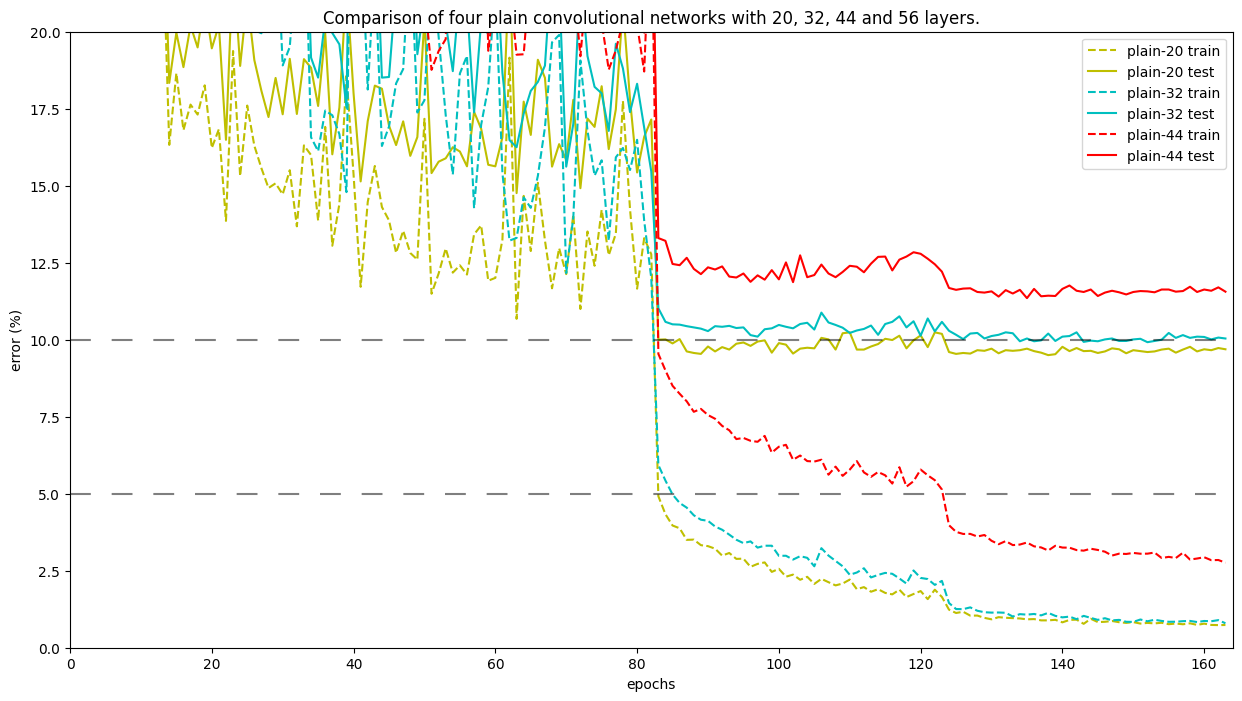

In [57]:
ns  = [3, 5, 7]
clr = ['y', 'c', 'r']


plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(15, 8))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [59]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44']
display(bests_df[['model', 'test_err']])

,model,test_err
138,PlainNet20,0.0950
152,PlainNet32,0.0992
135,PlainNet44,0.1135


### Resnet

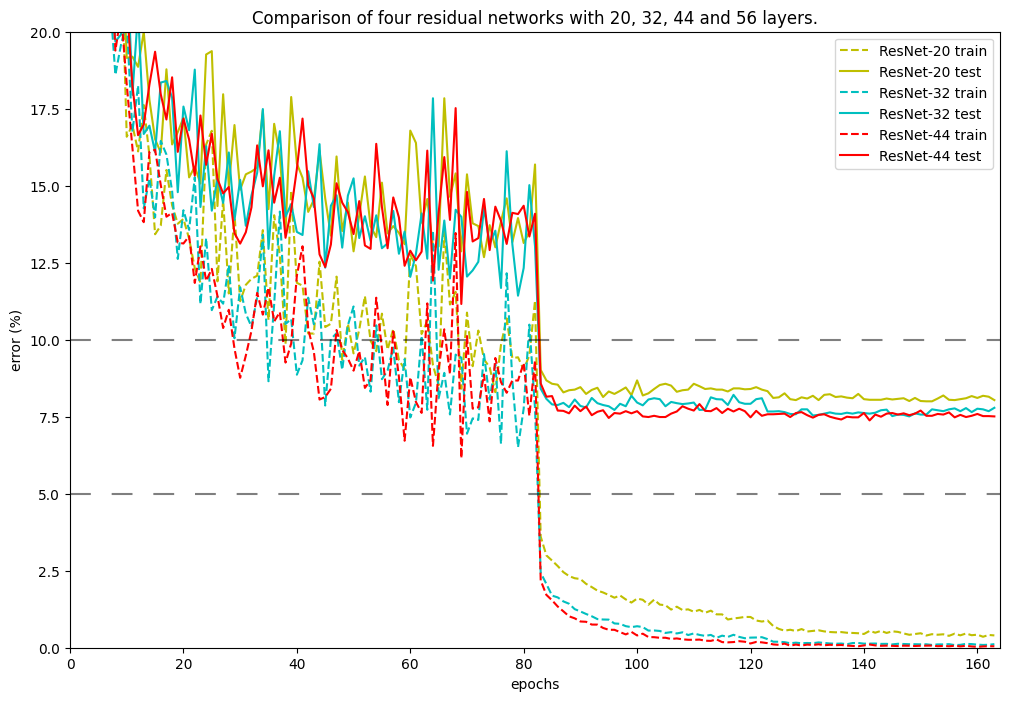

In [63]:
ns  = [3, 5, 7]
clr = ['y', 'c', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(12, 8))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [61]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44']
display(bests_df[['model', 'test_err']])


,model,test_err
151,ResNet20,0.0800
148,ResNet32,0.0751
141,ResNet44,0.0738


## Side-by-side plot

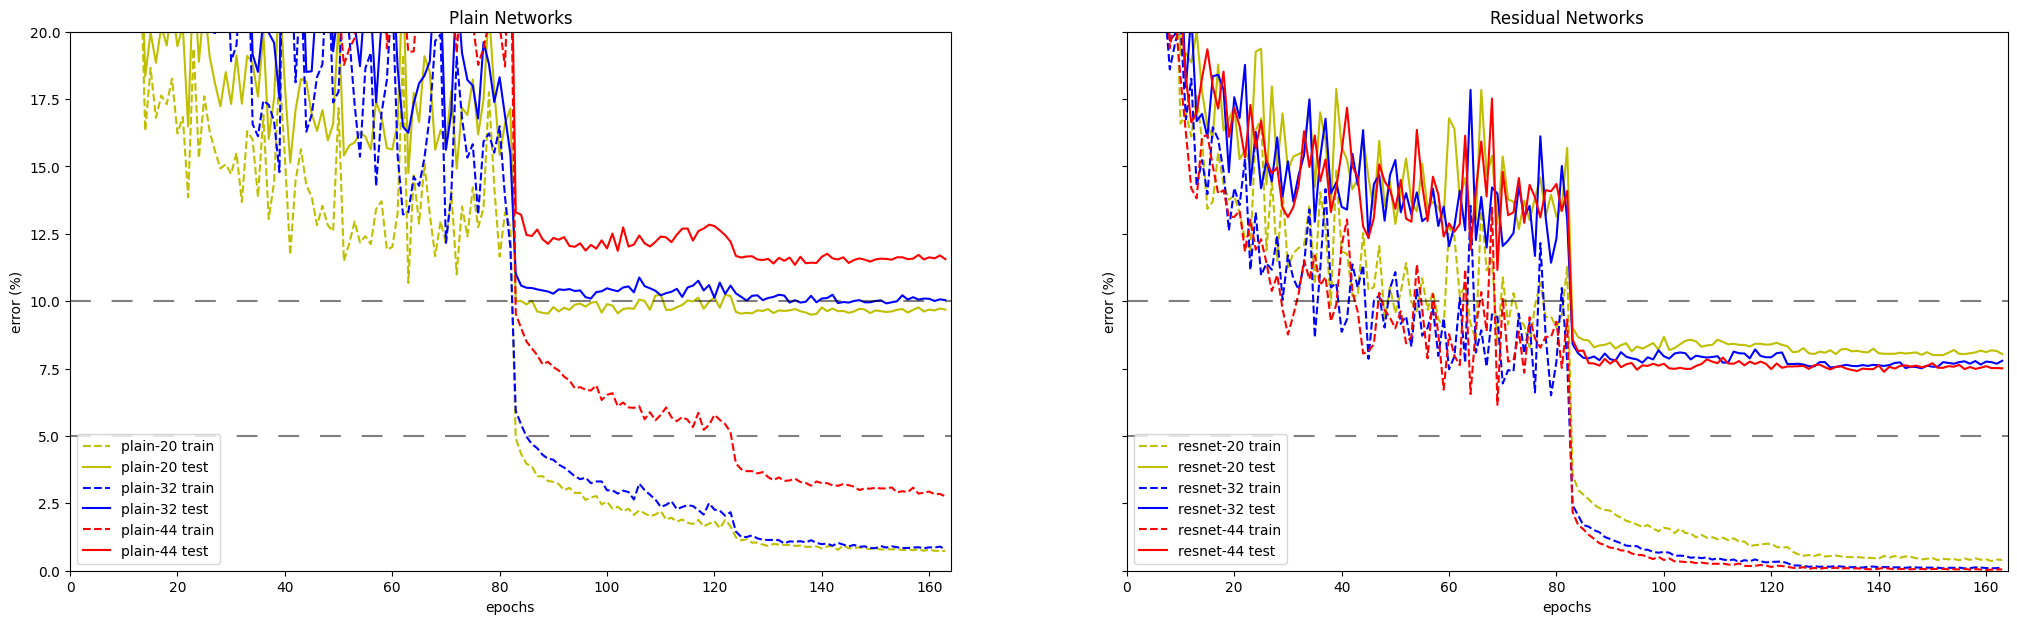

In [62]:
ns  = [3, 5, 7]
clr = ['y', 'b', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title, prefix):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'{prefix}-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'{prefix}-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='lower left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks', 'plain')
plot_results(resnet_dfs, ax2, 'Residual Networks', 'resnet')

Here the solid lines are the test are the test the dashed lines are the training